In [1]:
# Imports
%matplotlib notebook
# numpy, matplotlib, seaborn and matplotlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# missing data visualization library
import missingno as msno
sns.set_style('whitegrid')
# define data path
INPUT_PATH = "../data/%s.csv"
# define small samples to quickly explore data
read_rows = 300;

# Dataset Visualization Part

## Overview Part
This part is to overview the first N rows of the sample to get initial feeling of the dataset

In [ ]:
# load data head for overview
train_date_overview = pd.read_csv('../data/train_date.csv',nrows = read_rows)
#train_categorical_overview = pd.read_csv('../data/train_categorical.csv',nrows = read_rows)
#train_numeric_overview = pd.read_csv('../data/train_numeric.csv',nrows = read_rows)
#test_categorical_overview = pd.read_csv('../data/test_categorical.csv', nrows = read_rows)
#test_date_overview = pd.read_csv('../data/test_date.csv', nrows = read_rows)
#test_numeric_overview = pd.read_csv('../data/test_numeric.csv', nrows = read_rows)

In [ ]:
#train_numeric_overview
#train_categorical_overview
#train_date_overview
#test_numeric_overview
#test_categorical_overview
#test_date_overview 

## General Feature Exploration Part
This part is to explore the common feature

In [4]:
# function to calculate failure rate
def get_failure_rate(file_name):
    # will calculate the error rate from data on the file based on response col
    # Respons: 1 = Failed QC , 0 = Passed QC
    rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Response"])
    failure_rate = rows[rows.Response == 1].size / float(rows[rows.Response == 0].size)
    return failure_rate

In [ ]:
# function to calculate data size in 6 dataset
def explore_data_size():
    # explore the size (rows, cols) of each file
    data_files = ['train_numeric', 'train_date', 'train_categorical', 'test_numeric',
                  'test_date', 'test_categorical']
    stats = []
    for file_name in data_files:
        cols = pd.read_csv(INPUT_PATH % file_name, nrows=1)
        rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Id"])
        stats.append({'File': file_name, 'Rows': rows.shape[0], 'Columns': cols.shape[1]})
    # convert the result into a DataFrame so we can do plotting.
    df = pd.DataFrame(stats, columns=["File", "Rows", "Columns"])
    failure_rate = get_failure_rate('train_numeric')
    df["Error"] = 0
    df.loc[df.File == 'train_numeric', 'Error'] = failure_rate
    return df

In [ ]:
# Get data size
explore_data_size()

### Failure Rate for each station

In [19]:
# this part will use function in the belowing part
features = pd.read_csv('../data/train_numeric.csv', nrows=1).drop(['Response', 'Id'], axis=1).columns.values
line_features, station_features = get_features(features)

No. of lines: 4
No. of stations: 50
No. of features: 968


In [20]:
station_error = []
for s in station_features:
    cols = ['Id', 'Response']
    cols.extend(station_features[s])
    df = pd.read_csv('../data/train_numeric.csv', usecols=cols).dropna(subset=station_features[s], how='all')
    error_rate = df[df.Response == 1].size / float(df[df.Response == 0].size)
    station_error.append([df.shape[1]-2, df.shape[0], error_rate]) 
    
station_data = pd.DataFrame(station_error, 
                         columns=['Features', 'Samples', 'Error_Rate'], 
                         index=station_features).sort_index()
station_data

,Features,Samples,Error_Rate
S0,12,673862,0.005383
S1,2,673904,0.005380
S10,12,224540,0.005477
S11,12,225452,0.005320
S12,12,242061,0.005496
S13,2,242065,0.005496
S14,9,120625,0.005678
S15,9,121445,0.005298
S16,2,119139,0.005579
S17,2,123027,0.005410


<IPython.core.display.Javascript object>


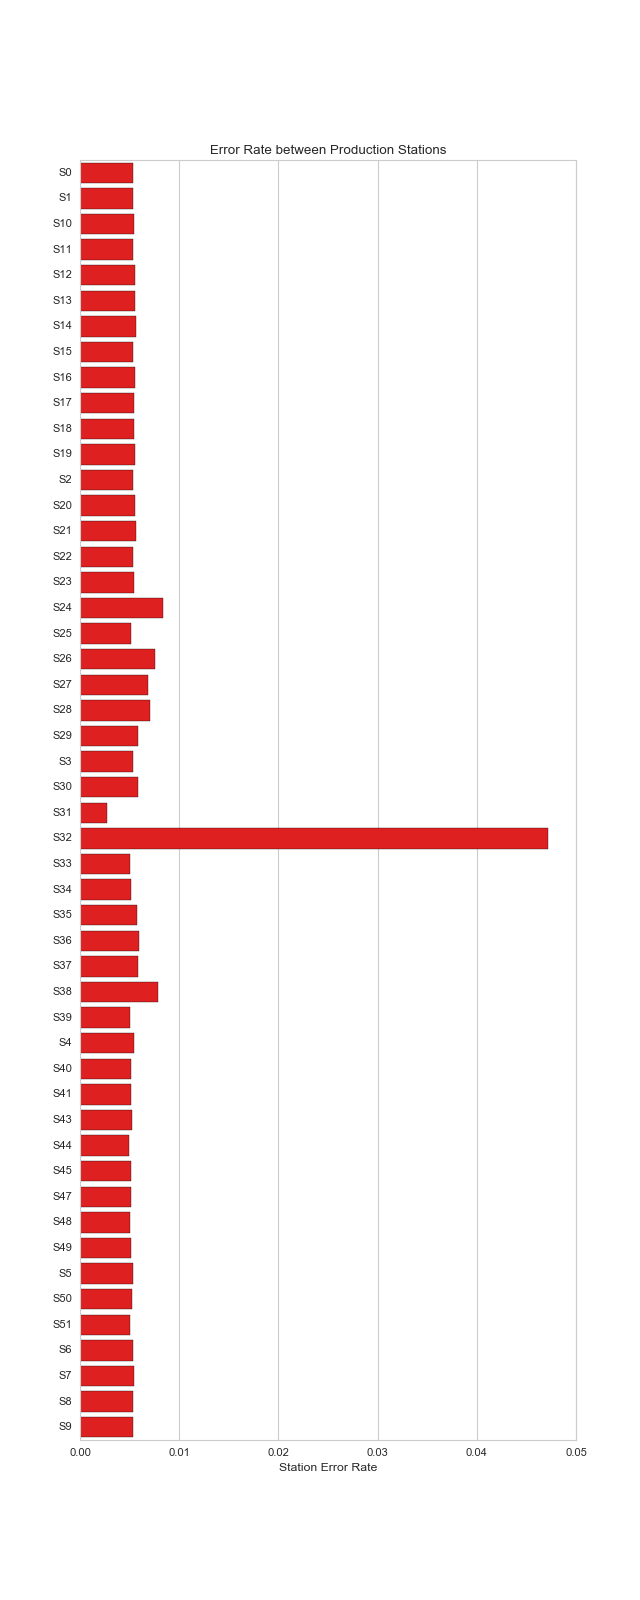

In [21]:
plt.figure(figsize=(8, 20))
sns.barplot(x='Error_Rate', y=station_data.index.values, data=station_data, color="red")
plt.title('Error Rate between Production Stations')
# of all the parts that pass through the station, counts the error rate for each station
plt.xlabel('Station Error Rate')
plt.show()
# station 32 used for R&D ?

In [5]:
# explore failure rate with a combination of stations
def explore_failure_rate_combine_station(STATIONS):
    train_numeric_part = pd.read_csv('../data/train_numeric.csv', nrows=10000)
    numeric_cols = train_numeric_part.drop(['Id','Response'], axis=1).count().reset_index().sort_values(by=0, ascending=False)
    numeric_cols['station'] = numeric_cols['index'].apply(lambda s: s.split('_')[1])
    numeric_cols = numeric_cols[numeric_cols['station'].isin(STATIONS)]
    numeric_cols = numeric_cols.drop_duplicates('station', keep='first')['index'].tolist()
    
    # Load the first feature column
    train_numeric = pd.read_csv('../data/train_numeric.csv', usecols=['Id'] + numeric_cols)
    train_numeric.columns = ['Id'] + STATIONS
    
    # Has value ->1 no value ->0
    for station in STATIONS:
        train_numeric[station] = 1 * (train_numeric[station] >= 0)
    # Group by station and output result
    response = pd.read_csv('../data/train_numeric.csv', usecols=['Id', 'Response'])
    train = response.merge(train_numeric, how='left', on='Id')
    train['cnt'] = 1
    failure_rate = train.groupby(STATIONS).sum()[['Response', 'cnt']]
    failure_rate['failure_rate'] = failure_rate['Response'] / failure_rate['cnt']
    return failure_rate
    # failure_rate.head(20)

In [7]:
combined_failure_rate = explore_failure_rate_combine_station(['S43','S44'])
combined_failure_rate

Response      cnt  failure_rate
S43 S44                                 
0   0        6757  1158403      0.005833
    1          42     6698      0.006271
1   0          80    18618      0.004297
    1           0       28      0.000000

In [20]:
# explore min and max value of each station
# data = pd.read_csv('../data/train_numeric.csv', nrows=100)

# def make_features(df):
#     new_features = pd.DataFrame({})
#     for s in station_features.keys():
#         station_data = df[station_features[s]]
#         col = s+'_max'
#         new_features[col] = station_data.max(axis=1).fillna(-1.)
#         col = s+'_min'
#         new_features[col] = station_data.min(axis=1).fillna(-1.)
#     return new_features

# data = make_features(data)
# data.max().max()
# data.min().min()

-1.0

## Numerical Feature Exploration Part

In [16]:
def get_number_features(station_features):
    total_features = 0
    for key in station_features.keys():
        total_features += len(station_features[key]) 
    return total_features

def get_features(feature_list):
    # function to group features by station or line of production the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]
    
    print 'No. of lines: '+ str(len(lines))
    print 'No. of stations: '+ str(len(stations))
    print 'No. of features: '+ str(int(get_number_features(station_features)))
    

    return (line_features, station_features)

In [ ]:
def explore_features(data_set_name,is_response):
    # how many units processed in each station
    # also percentage of failed/passed QS in each station
    if is_response :
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    else:
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Id"], axis=1).columns.values
    
    line_features, station_features = get_features(features)
    # create a dataframe cols: station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    ldf = pd.DataFrame(list({int(key[1:]): len(line_features[key]) for
                             key in line_features.keys()}.items()),
                       columns=["Line", "FeatureCount"])
    
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.1 - Features by Station",
                             figsize=(13,6), fontsize=12)
    
    line_features_plot = ldf.plot(x="Line",y="FeatureCount", kind="bar",
                             title="Fig.2 - Features by line",
                             figsize=(13,6), fontsize=12)
    
    #print 'No. of features:'+ str(int(get_number_features(station_features)))
    
    return line_features, station_features

In [ ]:
lf, sf = explore_features("train_numeric",True)

This part is to see how many parts per station, how many success and failure parts per station

In [ ]:
def explore_product_by_station(data_set_name,read_rows):
    # need to see how many product per station
    # features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    # line_features, station_features = get_features(features)
    station_features = sf
    dwb_result = []
    ppbs_result = []
    rows = 0
    # inside this loop we will try to calculate different data sets, this way we only read the
    # files once since it takes a while and produce multiple results
    for station in station_features:
        station_data = pd.read_csv(
            INPUT_PATH % data_set_name,
            usecols=station_features[station] + ['Id', 'Response'],nrows = read_rows)
        
        # need to get how many rows in the sample row
        if not rows:
            rows = station_data.shape[0]
        # need to store how many processed units in each station
        # only if all features in that station has value we conside unit processed in this station
        ppbs_result.append(
            {'Station': int(station[1:]),
             'Processed': station_data[station_features[station]].
             .all(axis=1).sum()})
        
        # data without blanks (dwb): take all rows and drop any row that has any blank
        # in any station column
        dwb = station_data.dropna(how="any")
        dwb_result.append([int(station[1:]), dwb.shape[0],
                       dwb[dwb["Response"] == 1].shape[0],
                       dwb[dwb["Response"] == 0].shape[0]])
        
    # convert list to a dataframe and prepare for the plot
    dwb_df = pd.DataFrame(
        dwb_result, columns=["Station", "Count", "Failed", "Passed"]).sort_values(by=["Station"])
    # calculate the error rate for each station
    dwb_df["Error"] = dwb_df.apply(lambda row: float(row["Failed"]) / (row["Count"] + 1), axis=1)
    
    # plot the stacked bar tot product/ station
    my_plot = dwb_df[["Station", "Failed", "Passed"]].plot(kind="bar", stacked=True, x="Station",
        title="Fig:3 - Products by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Record Count")
    
    # plot error rate per station
    my_plot = dwb_df[["Station", "Error"]].plot(
        kind="bar", x="Station",
        title="Fig:4 - Error by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Error %")
    
    # process the ppbs result to see how many products has been process by each station.
    ppbs_df = pd.DataFrame(
        ppbs_result, columns=['Station', 'Processed']).sort(columns=['Station'])
    # calculate the missed product for each station: all count - processed count
    ppbs_df["Missed"] = ppbs_df["Processed"].apply(lambda x: rows - x)
    # the plot
    ppbs_df.plot(x="Station", kind="bar", stacked=True,
            title="Fig: 5 - Products processed by each station",
            figsize=(13,6), fontsize=12)
    



In [ ]:
explore_product_by_station("train_numeric",300)

In [ ]:
# Value exploration by station part

In [ ]:
# overview again to compare with latter results
train_overview = pd.read_csv(INPUT_PATH % 'train_numeric',nrows = read_rows)
train_overview.head()

In [10]:
# overview again with respect to a station
def get_station(dataset, station, res = False, show_figure = True):
    overview = pd.read_csv(INPUT_PATH % dataset,nrows = read_rows)
#     print overview.head()
    if res:
        columns = overview.columns.drop(["Response", "Id"])
    else:
        columns = overview.columns.drop(["Id"])
        
    stations = set([item.split('_')[1] for item in list(columns)])
    station_features = {}
    for s in stations:
        station_features[s] = [item for item in list(columns) if '%s_' % s in item]  
#     print overview[station_features[station]].head()
    print np.unique(overview[station_features[station]].values)
    
    overview_explore_nan = pd.DataFrame(columns = stations) 
    # prepare for dataset with one station
    # if contain values not nan
    # if no values nan
    for s in stations:
        overview_explore_nan[s] = overview[station_features[s][0]]
    overview_explore_nan =overview_explore_nan[sorted(overview_explore_nan.columns, key=lambda item: int(item[1:]))]
    # visualize result in flow path
    msno.matrix(overview_explore_nan)
    # visualize result in bar counting total number of non-nan value
    # msno.bar(overview_explore_nan)
    # visualize result in correlation coeficient
    msno.heatmap(overview_explore_nan)

In [ ]:
# train_numeric
# train_date
# train_categorical
get_station('train_numeric', 'S0', True)

In [ ]:
get_station('train_date', 'S1', False)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan na

<IPython.core.display.Javascript object>


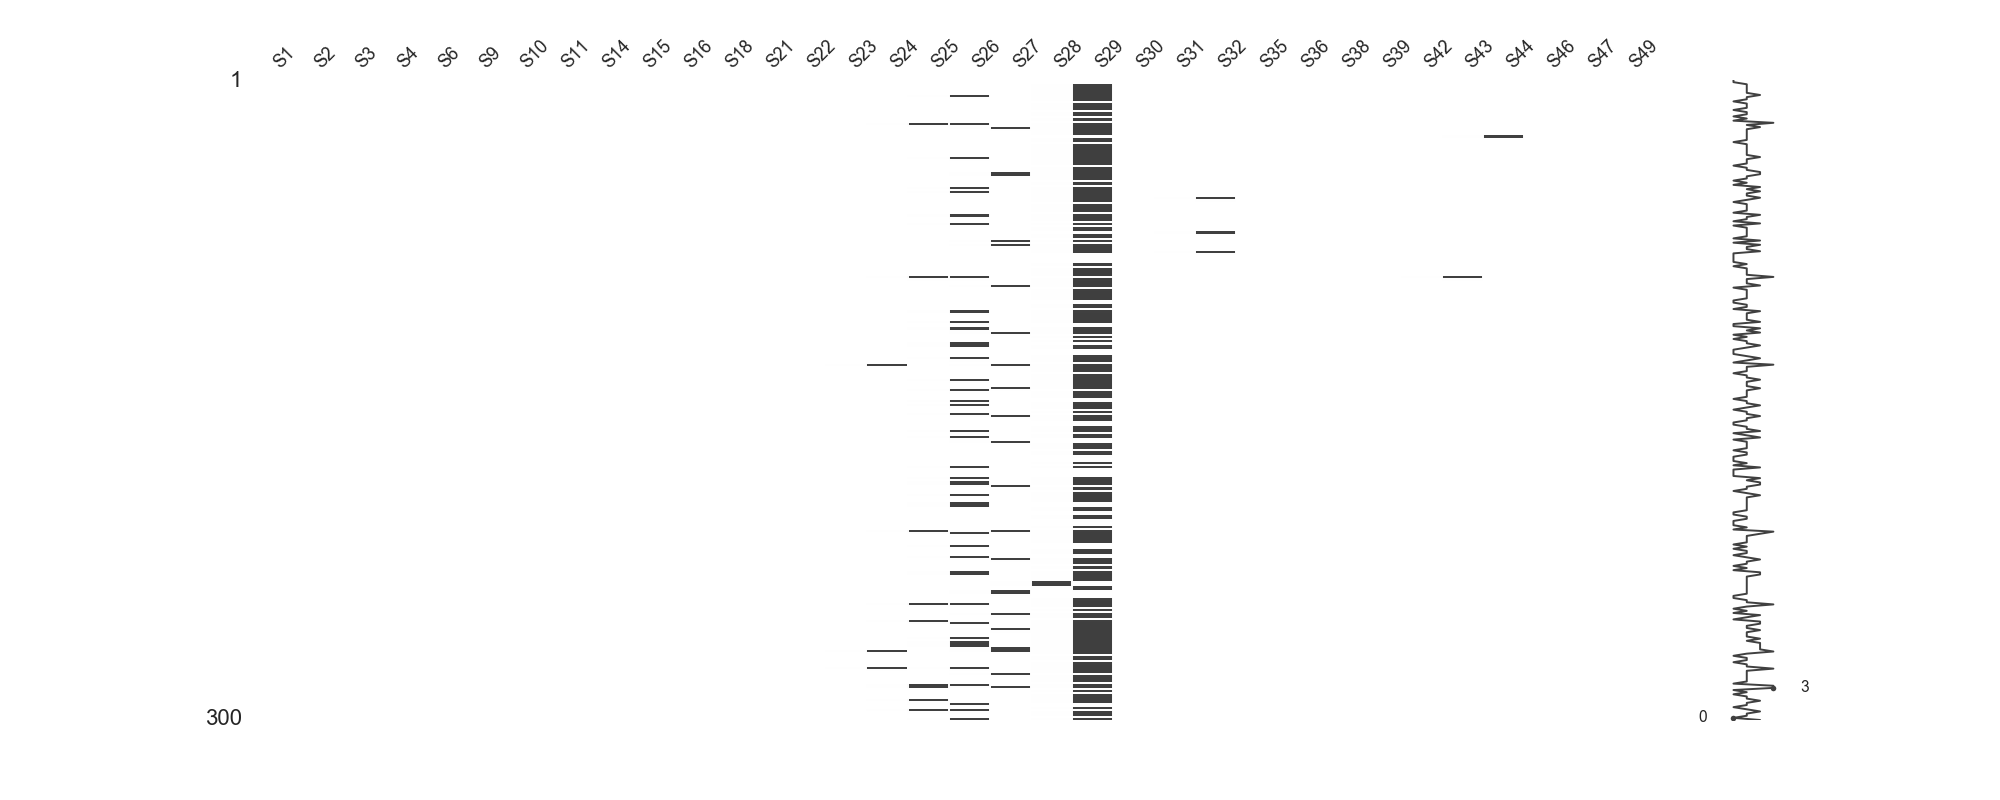

<IPython.core.display.Javascript object>


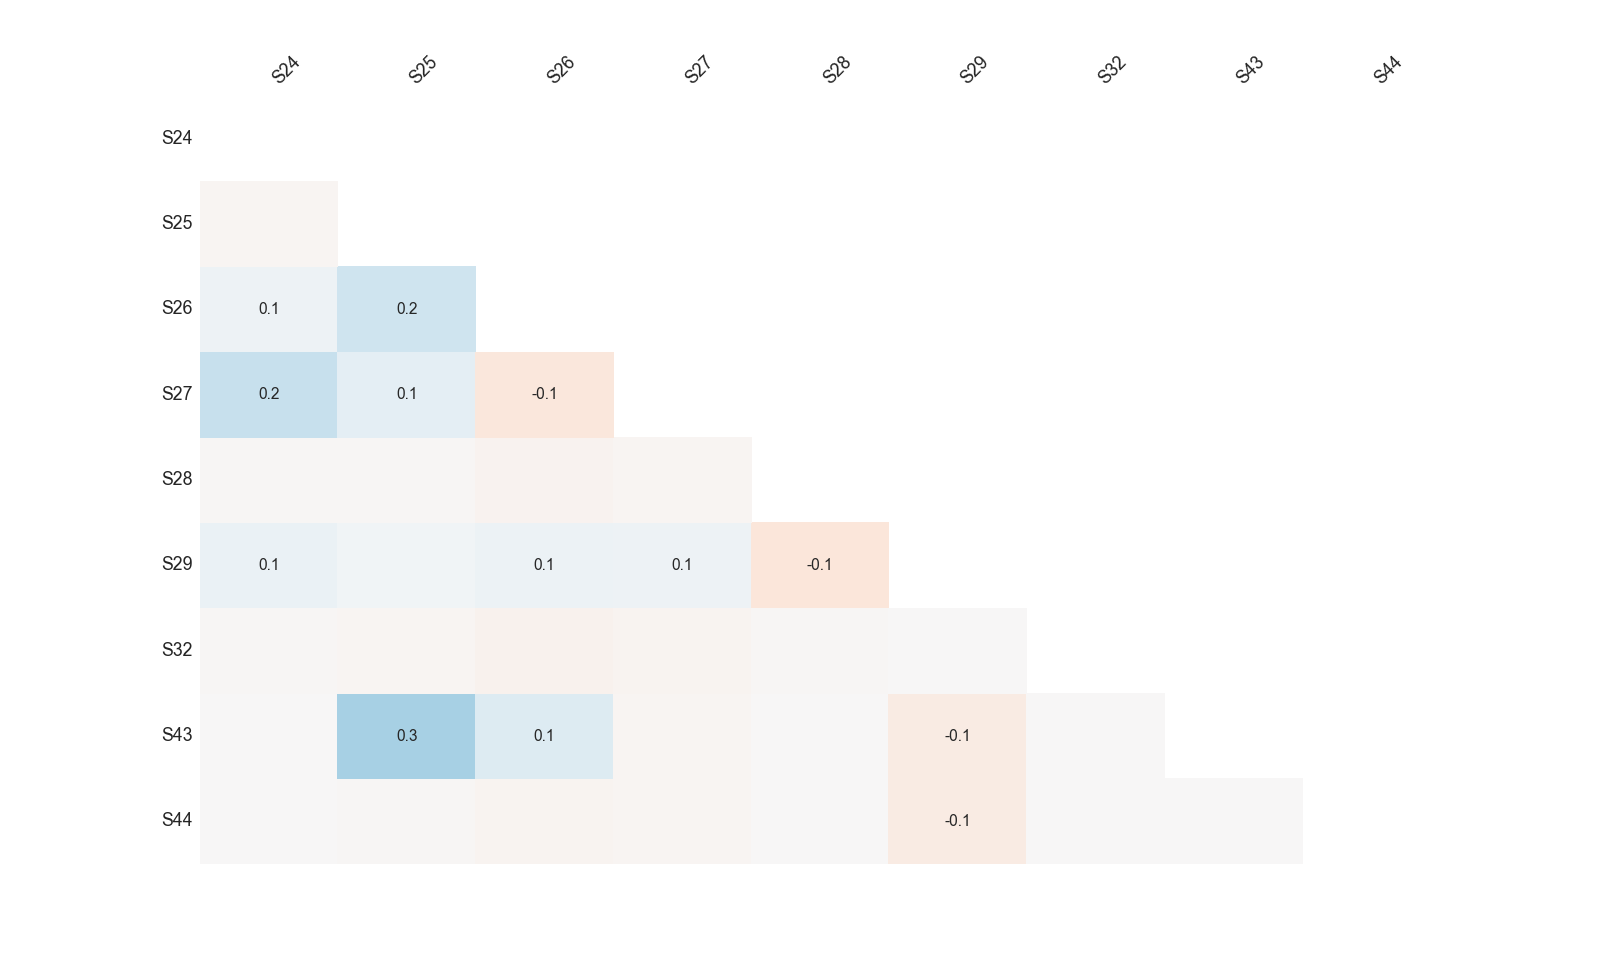

In [12]:
get_station('train_categorical', 'S32', False)

## Categorial Data Exploration Part

In [ ]:
lf, sf = explore_features("train_categorical",False)

In [ ]:
# this function is to explore sparsity rate per row
def explore_sparse_rate(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % data_set_name,nrows = read_rows).drop(["Id"], axis=1)
    sparse_rate_each_part = []
    sparse_rate_series = train_categorical.isnull().sum(axis = 1)/train_categorical.shape[1]
    sparse_rate_df = pd.DataFrame(
        sparse_rate_series, columns=['sparse_rate'])
    return sparse_rate_df

In [ ]:
explore_sparse_rate('train_categorical', 100)

In [ ]:
# This function is to get feeling of the TX value in the dataset
def explore_dintinct_Tx_value(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % 'train_categorical',nrows = read_rows)
    del train_categorical['Id']
    train_categorical_zeroes = train_categorical.fillna(0)
    train_categorical_zeroes = train_categorical_zeroes.values 
    return np.unique(train_categorical_zeroes[train_categorical_zeroes!=0.0])

In [ ]:
explore_dintinct_Tx_value('train_categorical', 30)

# Feature Enginnering Part

## Method 1 : Applying PCA for Dimension Reduction
Preliminary work to search for appropriate n component
benchmark: how many variance is explained or we maintain how much variance

In [ ]:
# import additional pakage
import math
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import preprocessing
# define chunksize how many rows load one time
chunksize  = 50000

In [ ]:
# Getting the column headers from first rows
# Reading as float32 to save Memory 
data = pd.read_csv(INPUT_PATH % 'train_numeric',nrows=1)
float_cols = [c for c in data]
float32_cols = {c: np.float32 for c in float_cols}

In [ ]:
# define the number of pc for preliminary decomposition
n_components = 968
predictors = [x for x in data.keys() if (x != 'Response' and x != 'Id')]

In [ ]:
def standard_feature_scaling(df):
    std_scale = preprocessing.StandardScaler().fit(df)
    df_std = pd.DataFrame(std_scale.transform(df))
    df_std.columns = df.columns
    df_std.index = df.index
    return df_std

In [ ]:
def mean_imputer(DF):
    fill_NaN = preprocessing.Imputer(missing_values=np.nan, strategy='mean')
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(DF))
    imputed_DF.columns = DF.columns
    imputed_DF.index = DF.index
    return imputed_DF

In [ ]:
ipca = IncrementalPCA(n_components=968)
# Due to the large dataset read data seperately in chunks and perform IncrementalPCA 
counter = 0
for chunk in pd.read_csv(INPUT_PATH % 'train_numeric', chunksize=chunksize,dtype=float32_cols):
    counter += chunksize
    print ('processed',counter,'samples')
# To do: what value to fill NA 
    imputed_chunk = chunk[predictors].fillna(0.09)
    #imputed_chunk = mean_imputer(chunk[predictors])
    scailed_chunk = standard_feature_scaling(imputed_chunk)
#    chunk  = scailed_chunk.fillna(0)
    ipca.partial_fit(scailed_chunk)
print ('Number of Samples Seen:',ipca.n_samples_seen_ )


In [ ]:
def get_explained_variance(pca_components):
    #print ('Explained variance by %d PCs:' %pca_components, np.sum(ipca.explained_variance_ratio_[:pca_components]))
    return np.sum(ipca.explained_variance_ratio_[:pca_components])

In [ ]:
# plot how many variance is explained based on how many n_components
n_components_value = range(968)
n_components_explained_variance = [get_explained_variance(x) for x in n_components_value]
explained_variance_pd = pd.DataFrame(n_components_explained_variance, columns=['explained_variance_rate'])
my_plot = explained_variance_pd.plot(title="explained_variance_rate", figsize=(10,6), fontsize=12)
my_plot.set_ylabel("Explained Variance Rate")
my_plot.set_xlabel("Number of Component")
n_components_explained_variance

In [ ]:
# Make Train DataFrame only with n PC 
PC_n = ['f'+str(x) for x in range(0,n_components)]
date_final = pd.DataFrame(columns=PC_n)
for cat in pd.read_csv(INPUT_PATH % 'train_numeric', chunksize=chunksize,dtype=float32_cols):
        cat  = cat.fillna(999)
        y=ipca.transform(cat[predictors])
        temp = cat['Id'].to_frame()
        for i in PC_n:
            temp[i]=0
        temp[PC_n]=y
        date_final = date_final.merge(temp, how='outer')
print (date_final)
date_final['Id'] = date_final['Id'].astype(np.int32)
# save new dataset to CSV file 
train_filename = 'train_numeric_SVD_%s.csv' % n_components
#date_final.to_csv(INPUT_PATH % train_filename,index=0)

In [ ]:
# Make Test DataFrame only with n PC 
PC_n = ['f'+str(x) for x in range(0,n_components)]
date_final = pd.DataFrame(columns=PC_n)
for cat in pd.read_csv('../input/test_numeric.csv', chunksize=chunksize,dtype=float32_cols):
        cat  = cat.fillna(999)
        y=ipca.transform(cat[predictors])
        temp = cat['Id'].to_frame()
        for i in PC_n:
            temp[i]=0
        temp[PC_n]=y
        date_final = date_final.merge(temp, how='outer')
date_final['Id'] = date_final['Id'].astype(np.int32)
test_filename = 'test_numeric_SVD_%s.csv' % n_components
# Save dataset to CSV file
#date_final.to_csv(INPUT_PATH % test_filename,index=0)

## Method 2 : XGBoost to select important features

choose 25 top date and numerical features reported by initial xgboost

In [11]:
# import additional package
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold

In [2]:
# Sample the data in a roundabout way to get 5 percent sample
date_chunks = pd.read_csv("../data/train_date.csv", index_col=0, chunksize=10000, dtype=np.float32)
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)
df_train = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y_sample = pd.read_csv("../data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[df_train.index].values.ravel()
x_sample = df_train.values

In [3]:
# # now just numerical feature to see the result
# num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
#                          usecols=list(range(969)), chunksize=10000, dtype=np.float32)
# df_train = pd.concat([nchunk for nchunk in num_chunks])

In [6]:
#TODO fit y ravel or not?
clf = XGBClassifier(base_score=0.005)
clf.fit(x_sample, y_sample)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


<IPython.core.display.Javascript object>


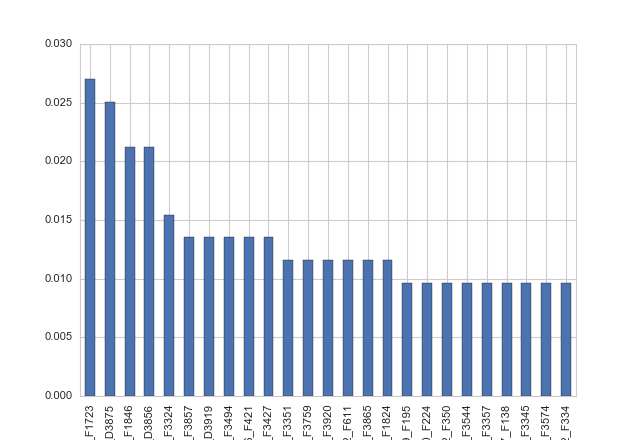

In [7]:
fea_importance = pd.DataFrame(clf.feature_importances_)
fea_importance.index = df_train.columns
fea_importance.columns=["feature_importance"]
# select 25 most important feature for xgboost
fea_importance_sorted = fea_importance.sort(['feature_importance'], ascending=[0])
important_feature_num_date = fea_importance_sorted.ix[0:25,0]
important_feature_num_date.plot(kind='bar')

In [ ]:
date_feature_value = pd.read_csv(INPUT_PATH % 'train_date',nrows=1).columns.drop(['Id']).values.tolist()
important_feature_num_list = list(set(important_feature_num_date.index.values.tolist())-set(date_feature_value))
important_feature_date_list = list(set(important_feature_num_date.index.values.tolist())-set(important_feature_num_list))

In [ ]:
# load entire dataset for these features. 
X = np.concatenate([
    pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=['Id']+important_feature_date_list).values,
    pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=['Id']+important_feature_num_list).values
], axis=1)

y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [ ]:
# create important feature dataframe and plot
# fea_importance = pd.DataFrame(clf.feature_importances_)
# fea_importance.index = df_train.columns
# fea_importance.columns=["feature_importance"]

# fea_importance_new = fea_importance[fea_importance.feature_importance >0.005]
# fea_importance_new.plot(kind="bar")

In [ ]:
# threshold for a manageable number of features
# plt.hist(clf.feature_importances_[clf.feature_importances_>0])
# important_indices = np.where(clf.feature_importances_>0.005)[0]
# print(important_indices)

In [ ]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
# n_date_features = 1156
# X = np.concatenate([
#     pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
#                 usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
#     pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
#                 usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - n_date_features])).values
# ], axis=1)

# y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [ ]:
# --------------------------------
# select top 20 important numerical feature
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)

## Method 3 : Magic Feature 
Start time.   Component(part) production start time

MF1.  difference of Id between current and previous rows 

MF2.  difference of Id between current and next rows 

MF3.  difference of Id between current and previous rows after sorting on increasing StartTime and Id

MF4.  difference of Id between current and next rows after sorting on increasing StartTime and Id


In [ ]:
ID_COLUMN = 'Id'
TARGET_COLUMN = 'Response'
train = pd.read_csv(INPUT_PATH %'train_numeric', usecols=[ID_COLUMN, TARGET_COLUMN])

test = pd.read_csv(INPUT_PATH %'test_numeric', usecols=[ID_COLUMN])

In [ ]:
# Start Time feature
train["StartTime"] = -1
test["StartTime"] = -1
# Duration time feature
train["Duration"] = -1
test["Duration"] = -1

In [ ]:
# fill in start time
for tr, te in zip(pd.read_csv(INPUT_PATH %'train_date', chunksize=50000), pd.read_csv(INPUT_PATH %'test_date', chunksize=50000)):
    #pick all columns except ID
    feats = np.setdiff1d(tr.columns, [ID_COLUMN])

    stime_tr = tr[feats].min(axis=1).values
    stime_te = te[feats].min(axis=1).values
    
    etime_tr = tr[feats].max(axis=1).values
    etime_te = te[feats].max(axis=1).values

    train.loc[train.Id.isin(tr.Id), 'StartTime'] = stime_tr
    test.loc[test.Id.isin(te.Id), 'StartTime'] = stime_te
    
    train.loc[train.Id.isin(tr.Id), 'Duration'] = etime_tr - stime_tr
    test.loc[test.Id.isin(te.Id), 'Duration'] = etime_te - stime_te

In [ ]:
ntrain = train.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)
# Begin to create MF1 & MF2
train_test['MF1'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['MF2'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['StartTime', 'Id'], ascending=True)
# Begin to create MF3 & MF4
train_test['MF3'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
train_test['MF4'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
train = train_test.iloc[:ntrain, :]
test = train_test.iloc[ntrain:, :]

features = np.setdiff1d(list(train.columns), [TARGET_COLUMN, ID_COLUMN])

In [ ]:
df_magic_feature_train = train[features]
df_magic_feature_test = test[features]

In [ ]:
df_magic_feature_train.head()

In [ ]:
# ntrain = train.shape[0]
# train_test = pd.concat((train, test)).reset_index(drop=True).reset_index(drop=False)
# # Begin to create MF1 & MF2
# train_test['MF1'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
# train_test['MF2'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

# train_test = train_test.sort_values(by=['StartTime', 'Id'], ascending=True)
# # Begin to create MF3 & MF4
# train_test['MF3'] = train_test[ID_COLUMN].diff().fillna(9999999).astype(int)
# train_test['MF4'] = train_test[ID_COLUMN].iloc[::-1].diff().fillna(9999999).astype(int)

# train_test = train_test.sort_values(by=['index']).drop(['index'], axis=1)
# train = train_test.iloc[:ntrain, :]

# features = np.setdiff1d(list(train.columns), [TARGET_COLUMN, ID_COLUMN])

# y = train.Response.ravel()
# train = np.array(train[features])

# print('train: {0}'.format(train.shape))
# prior = np.sum(y) / (1.*len(y))

## Combine all features and Finish feature engineering

In [ ]:
# train_feature will be the ensembled feature afterwards
train_feature = pd.DataFrame(X)


In [ ]:
# put important feature in the dataframe 
train_feature.columns = important_feature_num_date.index
train_feature = pd.concat([train_feature,df_magic_feature_train],axis=1)
#end of feature selection

In [ ]:
train_feature.shape

In [2]:
tl_df = pd.read_csv("../input/engineered_feature.csv", index_col=0, dtype=np.float32)

In [6]:
tl_df.columns


Index([u'target', u'P1', u'ord', u'group_len', u'fst', u'L3.fst', u'L3.lst',
       u'time_dtL3', u'time_idtL3', u'NAs_dtL3', u'NAs_idtL3', u'L3_S32_F3851',
       u'L3_S32_F3853', u'L3_S32_F3854', u'L1_S24_F1846', u'L3_S32_F3850',
       u'L1_S24_F1695', u'L1_S24_F1632', u'L3_S33_F3855', u'L1_S24_F1604',
       u'L3_S29_F3407', u'L3_S33_F3865', u'L3_S38_F3952', u'L1_S24_F1723',
       u'target_prev', u'target_next'],
      dtype='object')

In [30]:
tl_train = tl_df[tl_df["target"].notnull()]

In [31]:
target_y = tl_train["target"]

In [32]:
del tl_train["target"]

In [33]:
tl_test = tl_df[tl_df["target"].isnull()]

In [42]:
tl_train.head()

,P1,ord,group_len,fst,L3.fst,L3.lst,time_dtL3,time_idtL3,NAs_dtL3,NAs_idtL3,...,L1_S24_F1695,L1_S24_F1632,L3_S33_F3855,L1_S24_F1604,L3_S29_F3407,L3_S33_F3865,L3_S38_F3952,L1_S24_F1723,target_prev,target_next
ID,,,,,,,,,,,,,,,,,,,,,
4.0,0.0,0.0,2120808.0,82.239998,87.260002,87.290001,-0.11,2.842171e-14,28.0,-4.0,...,NaN,NaN,-0.119,NaN,-0.702,0.026,NaN,NaN,NaN,NaN
6.0,0.0,0.0,2120808.0,1313.119995,1315.729980,1315.750000,-0.01,0.000000e+00,-32.0,0.0,...,NaN,NaN,-0.029,NaN,0.082,-0.047,NaN,NaN,NaN,NaN
7.0,0.0,0.0,2120808.0,1618.699951,1624.400024,1624.420044,0.00,1.000000e-02,0.0,0.0,...,NaN,NaN,0.199,NaN,0.104,0.108,NaN,NaN,NaN,NaN
9.0,0.0,0.0,2120808.0,1149.199951,1154.119995,1154.160034,0.03,2.000000e-02,0.0,0.0,...,NaN,NaN,0.017,NaN,0.063,0.035,NaN,NaN,NaN,NaN
11.0,1.0,1.0,2.0,602.640015,606.000000,606.020020,0.00,-1.726000e+01,0.0,3.0,...,NaN,NaN,-0.074,NaN,0.101,-0.006,NaN,NaN,NaN,NaN


In [62]:
np.range(2)

AttributeError: 'module' object has no attribute 'range'

# Model Development 

## Model 1 : XGBoost

In [78]:
# self-defined xgb model wrapper including data processing, model fit, predict and result 
def modelfit(alg, dtrain, labels,useTrainCV=True, model_fit=True,model_predict=True,cv_folds=5, early_stopping_rounds=20):
    # trainCV with early stop so we don't need to use sciki-learn GridsearchCV , the later can't run in my computer
    best_threshold = 0.5
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
#         print cvresult
#         return
        alg.set_params(n_estimators=cvresult.shape[0])
        plt.figure(8)
        plt.plot(range(alg.get_params()['n_estimators']), cvresult["train-auc-mean"].values)
        plt.plot(range(alg.get_params()['n_estimators']), cvresult["test-auc-mean"].values)
        plt.legend(['train', 'test'], loc='upper left')
        plt.xlabel('training rounds')
        plt.ylabel('Auc')
        plt.show()
    if model_fit:
        #Fit the algorithm on the data
        alg.fit(dtrain.values, labels, eval_metric='auc')
        print ("fit done")
    if model_predict:
    #Predict training set:
        dtrain_predprob = alg.predict_proba(dtrain.values)[:,1]
        thresholds = np.linspace(0.01, 0.99, 50)
        mcc = np.array([matthews_corrcoef(labels, dtrain_predprob>thr) for thr in thresholds])    
        plt.figure(9)
        plt.plot(thresholds, mcc)
        plt.show()
        best_threshold = thresholds[mcc.argmax()]
        print('MCC is' + str(mcc.max()))
        print('best threshold is'+ str(best_threshold))
    return best_threshold
    #Print model report:
#     print ("\nModel Report")
#     print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

### Model Hyper-Parameter Tuning Part

In [ ]:
from sklearn.grid_search import GridSearchCV

In [47]:
# this part is for hyper-parameter tuning, but limited by my computer, 
# I can't run out of the result with gridsearchCV so instead i'm using cv
# provided by xgboost

# tunning 1 
# max_depth and min_child_weight

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=10, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_feature,y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_



NameError: name 'GridSearchCV' is not defined

In [ ]:
### Training and Cross Validation Part

[0]	train-auc:0.89502+0.00316209	test-auc:0.88173+0.00675742
[1]	train-auc:0.905433+0.00325761	test-auc:0.896089+0.00429825
[2]	train-auc:0.90735+0.0031015	test-auc:0.898277+0.00467344
[3]	train-auc:0.909871+0.00297149	test-auc:0.900627+0.00329445
[4]	train-auc:0.910226+0.00250745	test-auc:0.901471+0.00257696
[5]	train-auc:0.910958+0.00196082	test-auc:0.902541+0.00297087
[6]	train-auc:0.911605+0.00171347	test-auc:0.903406+0.00252414
[7]	train-auc:0.912101+0.00218948	test-auc:0.90345+0.00279555
[8]	train-auc:0.912966+0.00202179	test-auc:0.904029+0.0031327
[9]	train-auc:0.913465+0.00142471	test-auc:0.904072+0.00332658
[10]	train-auc:0.914147+0.00130943	test-auc:0.904383+0.00324569
[11]	train-auc:0.914884+0.00122598	test-auc:0.904572+0.00326858
[12]	train-auc:0.915176+0.00133696	test-auc:0.904701+0.00330094
[13]	train-auc:0.915279+0.00126461	test-auc:0.904766+0.00326977
[14]	train-auc:0.915489+0.00128983	test-auc:0.904878+0.00315954
[15]	train-auc:0.916072+0.00110297	test-auc:0.905497+0.0

<IPython.core.display.Javascript object>


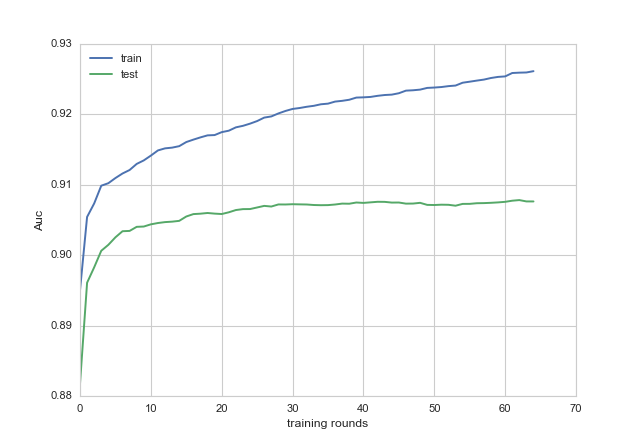

fit done


<IPython.core.display.Javascript object>


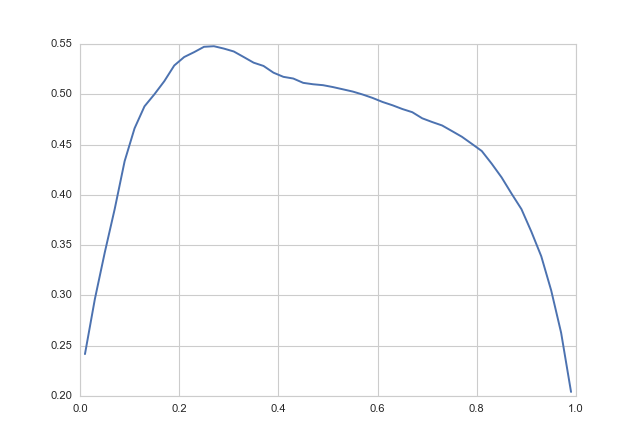

MCC is0.547805069119
best threshold is0.27


In [79]:
xgb_starter = XGBClassifier(
 learning_rate =0.09,
 n_estimators=65,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.7,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=0,
 base_score=0.005)

best_threshold = modelfit(xgb_starter, tl_train, target_y.values.ravel())


# load test data, predict labels and submit

In [ ]:
important_feature_date_list

In [ ]:
# load test data
test_feature = np.concatenate([
    pd.read_csv("../data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=['Id']+important_feature_date_list).values,
    pd.read_csv("../data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=['Id']+important_feature_num_list).values,
], axis=1)
test_feature = np.concatenate([test_feature,df_magic_feature_test.values],axis=1)

In [ ]:
test_feature.shape

In [67]:
test_feature = tl_test

In [69]:
test_feature

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
ID,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,2120808.0,792.719971,800.650024,800.700012,NaN,2.000000e-02,NaN,3.0,...,-0.007,NaN,-0.256,NaN,0.057,-0.095,NaN,0.021,NaN,NaN
2.0,0.0,0.0,2120808.0,1025.630005,1060.040039,1060.069946,-2.000000e-02,-1.100000e-01,-3.0,0.0,...,NaN,NaN,0.062,NaN,0.063,-0.193,NaN,NaN,NaN,NaN
3.0,0.0,0.0,2120808.0,671.919983,710.940002,711.080017,1.100000e-01,1.100000e-01,0.0,-28.0,...,-0.007,NaN,-0.119,NaN,0.057,-0.104,NaN,-0.041,NaN,NaN
5.0,0.0,0.0,2120808.0,255.449997,256.250000,256.279999,-2.842171e-14,1.000000e-02,4.0,32.0,...,NaN,NaN,-0.029,NaN,0.037,-0.039,NaN,NaN,NaN,NaN
8.0,0.0,0.0,2120808.0,743.380005,770.270020,770.280029,-1.000000e-02,-3.000000e-02,0.0,0.0,...,NaN,-0.085,-0.119,0.047,0.057,0.124,NaN,NaN,NaN,NaN
10.0,0.0,0.0,2120808.0,907.340027,911.270020,911.289978,-2.000000e-02,0.000000e+00,0.0,0.0,...,NaN,NaN,-0.029,NaN,0.057,-0.095,NaN,NaN,NaN,NaN
12.0,1.0,2.0,2.0,602.640015,606.000000,623.280029,1.726000e+01,1.724000e+01,-3.0,-3.0,...,NaN,NaN,-0.074,NaN,0.101,-0.006,0.006,NaN,0.0,NaN
15.0,0.0,0.0,2120808.0,575.679993,582.960022,582.979980,0.000000e+00,0.000000e+00,0.0,0.0,...,NaN,NaN,0.017,NaN,0.082,0.262,NaN,NaN,NaN,NaN
17.0,0.0,0.0,2120808.0,1411.010010,1411.359985,1411.400024,2.000000e-02,2.000000e-02,87.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
del test_feature['target']

KeyError: 'target'

In [41]:
test_feature.head()

,P1,ord,group_len,fst,L3.fst,L3.lst,time_dtL3,time_idtL3,NAs_dtL3,NAs_idtL3,...,L1_S24_F1695,L1_S24_F1632,L3_S33_F3855,L1_S24_F1604,L3_S29_F3407,L3_S33_F3865,L3_S38_F3952,L1_S24_F1723,target_prev,target_next
ID,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,2120808.0,792.719971,800.650024,800.700012,NaN,0.02,NaN,3.0,...,-0.007,NaN,-0.256,NaN,0.057,-0.095,NaN,0.021,NaN,NaN
2.0,0.0,0.0,2120808.0,1025.630005,1060.040039,1060.069946,-2.000000e-02,-0.11,-3.0,0.0,...,NaN,NaN,0.062,NaN,0.063,-0.193,NaN,NaN,NaN,NaN
3.0,0.0,0.0,2120808.0,671.919983,710.940002,711.080017,1.100000e-01,0.11,0.0,-28.0,...,-0.007,NaN,-0.119,NaN,0.057,-0.104,NaN,-0.041,NaN,NaN
5.0,0.0,0.0,2120808.0,255.449997,256.250000,256.279999,-2.842171e-14,0.01,4.0,32.0,...,NaN,NaN,-0.029,NaN,0.037,-0.039,NaN,NaN,NaN,NaN
8.0,0.0,0.0,2120808.0,743.380005,770.270020,770.280029,-1.000000e-02,-0.03,0.0,0.0,...,NaN,-0.085,-0.119,0.047,0.057,0.124,NaN,NaN,NaN,NaN


In [43]:
test_feature.columns = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24']

In [70]:
test_feature.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
ID,,,,,,,,,,,,,,,,,,,,,
1.0,0.0,0.0,2120808.0,792.719971,800.650024,800.700012,NaN,0.02,NaN,3.0,...,-0.007,NaN,-0.256,NaN,0.057,-0.095,NaN,0.021,NaN,NaN
2.0,0.0,0.0,2120808.0,1025.630005,1060.040039,1060.069946,-2.000000e-02,-0.11,-3.0,0.0,...,NaN,NaN,0.062,NaN,0.063,-0.193,NaN,NaN,NaN,NaN
3.0,0.0,0.0,2120808.0,671.919983,710.940002,711.080017,1.100000e-01,0.11,0.0,-28.0,...,-0.007,NaN,-0.119,NaN,0.057,-0.104,NaN,-0.041,NaN,NaN
5.0,0.0,0.0,2120808.0,255.449997,256.250000,256.279999,-2.842171e-14,0.01,4.0,32.0,...,NaN,NaN,-0.029,NaN,0.037,-0.039,NaN,NaN,NaN,NaN
8.0,0.0,0.0,2120808.0,743.380005,770.270020,770.280029,-1.000000e-02,-0.03,0.0,0.0,...,NaN,-0.085,-0.119,0.047,0.057,0.124,NaN,NaN,NaN,NaN


In [71]:
# generate predictions at the chosen threshold
preds = (xgb_starter.predict_proba(test_feature)[:,1] > best_threshold).astype(np.int8)

In [72]:
# and submit
sub = pd.read_csv("../data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")